## Firing rate networks

### Decision model

In [1]:
from collections import OrderedDict
import brainpy as bp

bp.backend.set(backend='numba', dt=0.1)


class Decision(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  @staticmethod
  def derivative(s1, s2, t, I, coh,
                 JAext, J_rec, J_inh, I_0,
                 a, b, d, tau_s, gamma):
    I1 = JAext * I * (1. + coh)
    I2 = JAext * I * (1. - coh)

    I_syn1 = J_rec * s1 - J_inh * s2 + I_0 + I1
    r1 = (a * I_syn1 - b) / (1. - bp.ops.exp(-d * (a * I_syn1 - b)))
    ds1dt = - s1 / tau_s + (1. - s1) * gamma * r1

    I_syn2 = J_rec * s2 - J_inh * s1 + I_0 + I2
    r2 = (a * I_syn2 - b) / (1. - bp.ops.exp(-d * (a * I_syn2 - b)))
    ds2dt = - s2 / tau_s + (1. - s2) * gamma * r2

    return ds1dt, ds2dt

  def __init__(self, size, coh, JAext=.00117, J_rec=.3725, J_inh=.1137,
               I_0=.3297, a=270., b=108., d=0.154, tau_s=.06, gamma=0.641,
               **kwargs):
    # parameters
    self.coh = coh
    self.JAext = JAext
    self.J_rec = J_rec
    self.J_inh = J_inh
    self.I0 = I_0
    self.a = a
    self.b = b
    self.d = d
    self.tau_s = tau_s
    self.gamma = gamma

    # variables
    self.s1 = bp.ops.ones(size) * .06
    self.s2 = bp.ops.ones(size) * .06
    self.input = bp.ops.zeros(size)

    self.integral = bp.odeint(f=self.derivative, method='rk4', dt=0.01)

    super(Decision, self).__init__(size=size, **kwargs)

  def update(self, _t):
    for i in range(self.size):
      self.s1[i], self.s2[i] = self.integral(self.s1[i], self.s2[i], _t,
                                             self.input[i], self.coh,
                                             self.JAext, self.J_rec,
                                             self.J_inh, self.I0,
                                             self.a, self.b, self.d,
                                             self.tau_s, self.gamma)
      self.input[i] = 0.










In [2]:
def phase_analyze(I, coh):
  decision = Decision(1, coh=coh)

  phase = bp.analysis.PhasePlane(decision.integral,
                                 target_vars=OrderedDict(s2=[0., 1.],
                                                         s1=[0., 1.]),
                                 fixed_vars=None,
                                 pars_update=dict(I=I, coh=coh,
                                                  JAext=.00117, J_rec=.3725,
                                                  J_inh=.1137, I_0=.3297,
                                                  a=270., b=108., d=0.154,
                                                  tau_s=.06, gamma=0.641),
                                 numerical_resolution=.001,
                                 options={'escape_sympy_solver': True})

  phase.plot_nullcline()
  phase.plot_fixed_point()
  phase.plot_vector_field(show=True)

plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.06176109215560733, s1=0.061761097890810475 is a stable node.
Fixed point #2 at s2=0.029354239100062428, s1=0.18815448592736211 is a saddle node.
Fixed point #3 at s2=0.0042468423702408655, s1=0.6303045696241589 is a stable node.
Fixed point #4 at s2=0.6303045696241589, s1=0.004246842370235128 is a stable node.
Fixed point #5 at s2=0.18815439944520335, s1=0.029354240536530615 is a saddle node.
plot vector field ...


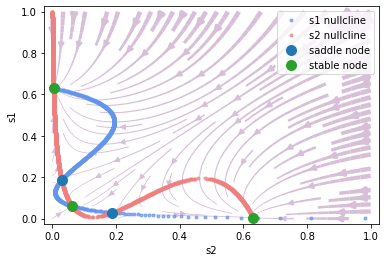

In [3]:
# no input
phase_analyze(I=0., coh=0.)

coherence = 0%
plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.6993504413889349, s1=0.011622049526766405 is a stable node.
Fixed point #2 at s2=0.49867489858358865, s1=0.49867489858358865 is a saddle node.
Fixed point #3 at s2=0.011622051540013889, s1=0.6993504355529329 is a stable node.
plot vector field ...


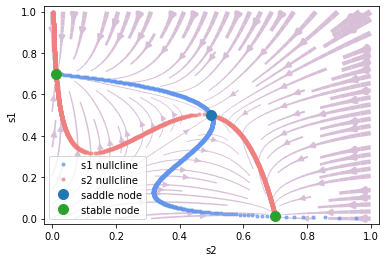

coherence = 51.2%
plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.5673124813731691, s1=0.2864701069327971 is a saddle node.
Fixed point #2 at s2=0.6655747347157656, s1=0.027835279565912054 is a stable node.
Fixed point #3 at s2=0.005397687847426814, s1=0.7231453520305031 is a stable node.
plot vector field ...


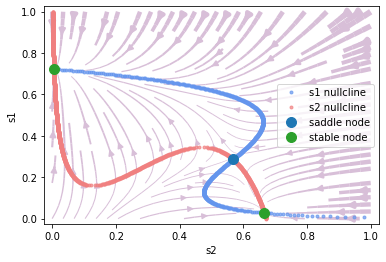

coherence = 100%
plot nullcline ...
plot fixed point ...
Fixed point #1 at s2=0.0026865954387078755, s1=0.7410985604497689 is a stable node.
plot vector field ...


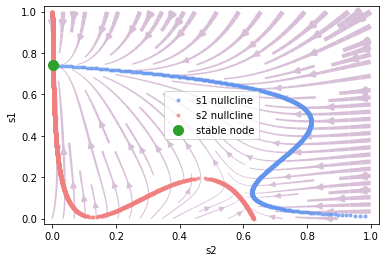

In [4]:
# coherence = 0%
print("coherence = 0%")
phase_analyze(I=30., coh=0.)

# coherence = 51.2%
print("coherence = 51.2%")
phase_analyze(I=30., coh=0.512)

# coherence = 100%
print("coherence = 100%")
phase_analyze(I=30., coh=1.)

### CANN

In [5]:
import brainpy as bp
import numpy as np
bp.backend.set(backend='numpy', dt=0.1)

class CANN1D(bp.NeuGroup):
  target_backend = ['numpy', 'numba']

  def __init__(self, num, tau=1., k=8.1, a=0.5, A=10., J0=4.,
               z_min=-np.pi, z_max=np.pi, **kwargs):
    # parameters
    self.tau = tau  # The synaptic time constant
    self.k = k      # Degree of the rescaled inhibition
    self.a = a      # Half-width of the range of excitatory connections
    self.A = A      # Magnitude of the external input
    self.J0 = J0    # maximum connection value

    # feature space
    self.z_min = z_min
    self.z_max = z_max
    self.z_range = z_max - z_min
    self.x = np.linspace(z_min, z_max, num)  # The encoded feature values

    # variables
    self.u = np.zeros(num)
    self.input = np.zeros(num)

    # The connection matrix
    self.conn_mat = self.make_conn(self.x)

    super(CANN1D, self).__init__(size=num, **kwargs)

    self.rho = num / self.z_range   # The neural density
    self.dx = self.z_range / num    # The stimulus density

  @staticmethod
  @bp.odeint(method='rk4', dt=0.05)
  def int_u(u, t, conn, k, tau, Iext):
    r1 = np.square(u)
    r2 = 1.0 + k * np.sum(r1)
    r = r1 / r2
    Irec = np.dot(conn, r)
    du = (-u + Irec + Iext) / tau
    return du

  def dist(self, d):
    d = np.remainder(d, self.z_range)
    d = np.where(d > 0.5 * self.z_range, d - self.z_range, d)
    return d

  def make_conn(self, x):
    assert np.ndim(x) == 1
    x_left = np.reshape(x, (-1, 1))
    x_right = np.repeat(x.reshape((1, -1)), len(x), axis=0)
    d = self.dist(x_left - x_right)
    Jxx = self.J0 * np.exp(-0.5 * np.square(d / self.a)) / (
            np.sqrt(2 * np.pi) * self.a)
    return Jxx

  def get_stimulus_by_pos(self, pos):
    return self.A * np.exp(-0.25 * np.square(self.dist(self.x -
                                                       pos) / self.a))

  def update(self, _t):
    self.u = self.int_u(self.u, _t, self.conn_mat, self.k, self.tau,
                        self.input)
    self.input[:] = 0.


def plot_animate(frame_step=5, frame_delay=50):
  bp.visualize.animate_1D(dynamical_vars=[{'ys': cann.mon.u, 'xs': cann.x,
                                           'legend': 'u'}, {'ys': Iext,
                                                            'xs': cann.x, 'legend': 'Iext'}],
                          frame_step=frame_step, frame_delay=frame_delay,
                          show=True)

In [6]:
cann = CANN1D(num=512, k=0.1, monitors=['u'])

I1 = cann.get_stimulus_by_pos(0.)
Iext, duration = bp.inputs.constant_current([(0., 1.), (I1, 8.), (0., 8.)])
cann.run(duration=duration, inputs=('input', Iext))

In [7]:
# define function
def plot_animate(frame_step=5, frame_delay=50):
    bp.visualize.animate_1D(dynamical_vars=[{'ys': cann.mon.u, 'xs': cann.x,
                                             'legend': 'u'}, {'ys': Iext,
                                             'xs': cann.x, 'legend': 'Iext'}],
                            frame_step=frame_step, frame_delay=frame_delay,
                            show=True)


# call the function
# plot_animate(frame_step=1, frame_delay=100)

In [8]:
cann = CANN1D(num=512, k=8.1, monitors=['u'])

dur1, dur2, dur3 = 10., 30., 0.
num1 = int(dur1 / bp.backend.get_dt())
num2 = int(dur2 / bp.backend.get_dt())
num3 = int(dur3 / bp.backend.get_dt())
Iext = np.zeros((num1 + num2 + num3,) + cann.size)
Iext[:num1] = cann.get_stimulus_by_pos(0.5)
Iext[num1:num1 + num2] = cann.get_stimulus_by_pos(0.)
Iext[num1:num1 + num2] += 0.1 * cann.A * np.random.randn(num2, *cann.size)
cann.run(duration=dur1 + dur2 + dur3, inputs=('input', Iext))

# plot_animate()

In [9]:
cann = CANN1D(num=512, k=8.1, monitors=['u'])

dur1, dur2, dur3 = 20., 20., 20.
num1 = int(dur1 / bp.backend.get_dt())
num2 = int(dur2 / bp.backend.get_dt())
num3 = int(dur3 / bp.backend.get_dt())
position = np.zeros(num1 + num2 + num3)
position[num1: num1 + num2] = np.linspace(0., 12., num2)
position[num1 + num2:] = 12.
position = position.reshape((-1, 1))
Iext = cann.get_stimulus_by_pos(position)
cann.run(duration=dur1 + dur2 + dur3, inputs=('input', Iext))

# plot_animate()